<a href="https://colab.research.google.com/github/ngnawejonas/gp_moe/blob/master/gp_functions_TrainFri10_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.overleaf.com/7889766968wqgtbpbrrkkh <br/>
report: https://www.overleaf.com/3871269128ncpcvgbwkrsy

In [0]:
# !git clone https://github.com/ngnawejonas/gp_moe.git
# %cd gp_moe
# !pip install pot
# !pip install GPy

In [0]:
from gp import *
# import ot
import GPy
%matplotlib inline

### Barycenter of GMMs

In [0]:
def fixed_point_K(gmm, eps=1e-6):
    n = gmm.get_params()['n_components']
    C_current = gmm.covariances_[0]
    precision = eps + 1
    n_iter = 0
    while precision > eps and n_iter < 100:
        C_half = mat_sqrt(C_current)
        Sum = np.zeros_like(C_current)            
        for j in range(n):
            Cov_j = mat_square(gmm.covariances_[j])
            sCs = C_half @ Cov_j @ C_half
            Sum += (1/n) * mat_sqrt(sCs) 
#         C_new =  Sum
        C_new = (np.linalg.inv(C_half) @ mat_square(Sum) @ np.linalg.inv(C_half))
        precision = np.linalg.norm(C_new - C_current)
        C_current = C_new
        n_iter += 1
    #end while
    print('n_iter: ', n_iter,', precision: ', precision)
    return C_current

def barycenter(gmm, fp=False):
    n = gmm.get_params()['n_components']        
    m = np.zeros_like(gmm.means_[0])
    L = np.zeros_like(gmm.covariances_[0])
    for j in range(n):
        m += (1/n) * gmm.means_[j]
        L += (1/n) * mat_sqrt(gmm.covariances_[j])
    C = mat_square(L)
    if fp:
        C  = fixed_point_K(gmm)
    return m, C

(300, 2)


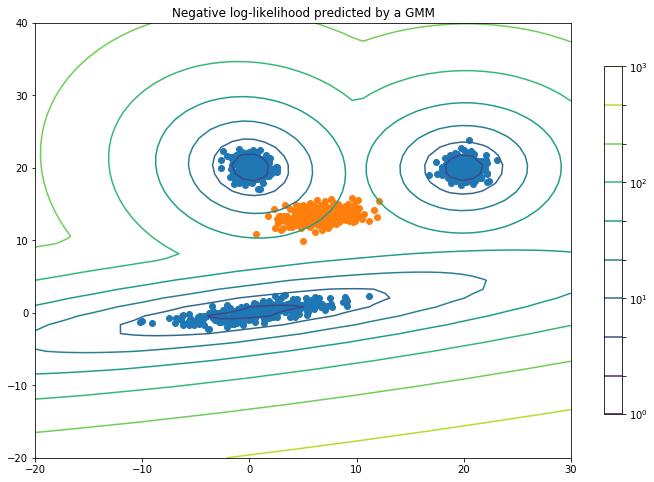

In [0]:
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(42)

# generate spherical data centered on (20, 20)
shifted_gaussian1 = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate spherical data centered on (20, 20)
shifted_gaussian2 = np.random.randn(n_samples, 2) + np.array([0, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian1, shifted_gaussian2, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(12,8))
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1])
###generate barycenter points
m_, C_ = barycenter(gmm,fp=False)
Xb = multivariateGaussianDraw(m_, C_, ndraws=n_samples)
print(Xb.shape)
plt.scatter(Xb[:,0], Xb[:,1])
##
plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


In [0]:
gmm.covariances_[2]

array([[13.4599313 ,  2.49152849],
       [ 2.49152849,  0.8784688 ]])

In [0]:
m, C = barycenter(gmm, fp=True)

n_iter:  5 , precision:  3.449044266252459e-07


In [0]:
C/2

array([[13.38142808,  2.4145592 ],
       [ 2.4145592 ,  0.78113715]])

### Data

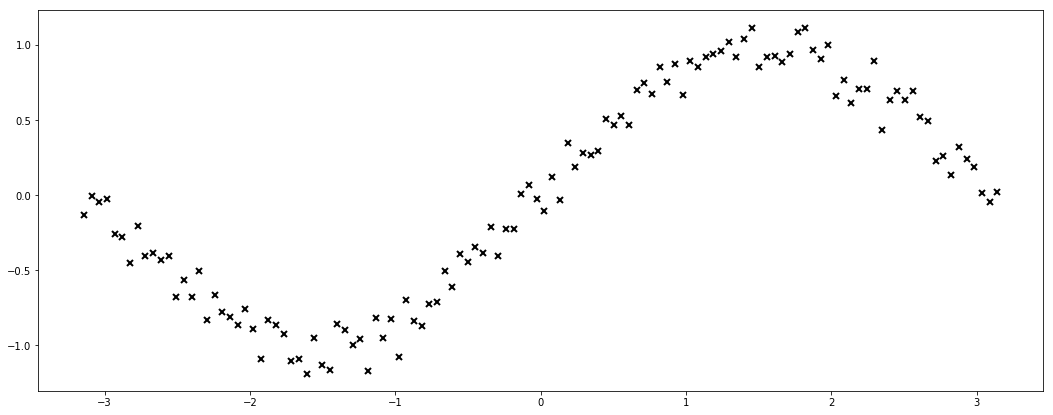

In [0]:
# lambda function, call f(x) to generate data
#f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)
f = lambda x: np.sin(x)
N = 120
# N equally spaced sample locations 
X = np.linspace(-np.pi, np.pi, N)[:,None]

# y = f(X) + epsilon
y = f(X) + np.random.normal(0., 0.1, (N,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(18, 7))

# # Plot observations
plt.plot(X, y, "kx", mew=2);

# # Annotate plot
# plt.xlabel("x"), plt.ylabel("f")
# plt.legend(labels=["sample points"]);

### Distributed GPs class

In [0]:
class DistributedGPRegression():
    def __init__(self, X, y, n):
        self.n = n  # number of experts
        self.Experts = []
        self.X = X
        self.y = y
        for i in range(n):
            params = np.array([0, np.log(0.1 + 0.01*i), 0])
            kernel = RadialBasisFunction(params)
            Xi = self.X[i*(N//n): (i+1)*(N//n)]
            yi = self.y[i*(N//n): (i+1)*(N//n)]
            gp = GaussianProcessRegression(Xi, yi, kernel)
            self.Experts.append(gp)
        
    def logMl(self, params=None):
        f = 0.
        for i in range(self.n):
            f = f + self.Experts[i].logMarginalLikelihood(params)
        return f

    def gradLogMl(self, params=None):
        gradf = 0.
        for i in range(self.n):
            gradf = gradf + self.Experts[i].gradLogMarginalLikelihood(params)
        return gradf

    def train(self, disp=True):  # Optimize the sum of log-marginal likelihood
        params = np.random.randn(3,)
        res = minimize(self.logMl, params, method='BFGS',
                       jac=self.gradLogMl, options={'disp': disp})
        # update the experts
        for i in range(self.n):
            self.Experts[i].k.setParams(res.x)
        print("Train Successfull!")

    def experts_preds(self, Xa):
        """returns the predictions m, Cov of the experts on data Xa
           for the Cov the cholesky decomposition will be returned
        """
        preds =[]
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            assert is_symmetric(cov_k)
            assert is_psd(cov_k, cholesky_test=True)
            L_k = mat_sqrt(cov_k)
            preds.append((m_k, L_k))
        return preds
    
    def fixed_point_K(self, preds, N, ksi, eps=1e-6):
        C_current = np.random.randn(N,N)#np.identity(N)
        C_current = (C_current + C_current.T)/2 #--> symmetry
        C_current += N*np.identity(N)
        precision = eps + 1
        n_iter = 0
        print('starting iterations...')
        while precision > eps and n_iter < 100:
            C_half = mat_sqrt(C_current)
            Sum = np.zeros((N,N), dtype='complex128')            
            for j in range(self.n):
                Cov_j = mat_square(preds[j][1])
                sCs = C_half @ Cov_j @ C_half
#                 print("expert", j, is_psd(sCs), is_psd(sCs, cholesky_test=True), " S = ", sCs)
                try:
#                   M =  mat_sqrt(sCs) 
#                   for i in range(N):
#                     M[i] *= ksi[j][i]
#                   #
#                   Sum += M
                  Sum += ksi[j][:,None] * mat_sqrt(sCs) 
                except:
                  Sum += ksi[j] * mat_sqrt(sCs)
#             C_new =  Sum
            C_new = (np.linalg.inv(C_half) @ mat_square(Sum) @ np.linalg.inv(C_half))
            precision = np.linalg.norm(C_new - C_current)
            C_current = C_new
            n_iter += 1
            print('n_iter: ', n_iter,', precision: ', precision)
        #end while
#         print('n_iter: ', n_iter,', precision: ', precision)
        return C_current

    
    def barycenter(self, Xa):
        N, D = Xa.shape
        preds = self.experts_preds(Xa)
        m = np.zeros(N)
        L = np.zeros((N,N))
        for j in range(self.n):
            m += preds[j][0]
            L += preds[j][1]
        m = m/self.n
        L = L/self.n
        C = mat_square(L)
#         C  = self.fixed_point_K(preds, N)
        return m, C

    def gbarycenter(self, Xa, ksi = 'default'):
        N, D = Xa.shape
        preds = self.experts_preds(Xa)
        if ksi is 'default':
            ksi = np.ones(self.n)/self.n
        elif ksi is 'opt':
            ksi = np.zeros((self.n, N))
            #prior covariance of matrix of Xa
            sigma_ss = np.diag(self.Experts[0].k.covMatrix(Xa))
            print(sigma_ss)
            for j in range(self.n):
              sigma_k_s = np.diag(preds[j][1])
              ksi[j] = 0.5 * (np.log(sigma_ss) - np.log(sigma_k_s))
            ksi /= ksi.sum(0)
#             print(ksi)
            assert ((ksi.sum(0)-1)< 1e-7).all()
        m = np.zeros(N)
        L = np.zeros((N,N), dtype='complex128')
        for j in range(self.n):
            print("shapes ", ksi[j].shape, preds[j][0].shape)
            m += ksi[j] * preds[j][0]
#             try:
#               L += ksi[j][:,None] * preds[j][1]
#             except:
#               L += ksi[j] * preds[j][1]
    
#         C = mat_square(L)
        C  = self.fixed_point_K(preds, N, ksi)
        return m, C
    
    def predict_poe(self, Xa):
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros(N)
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            # invert the diagonal of cov
            inv_diag = 1/np.diag(cov_k)
            sigma_star = sigma_star + inv_diag
            sum_star = sum_star + inv_diag * m_k
            
        sigma_star = 1 / sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        cov_star = sigma_star * np.identity(N)
        m_star = sigma_star * sum_star
        return m_star.flatten(), cov_star

    def predict_gpoe(self, Xa, betas='default'):
        if betas is 'default':
            betas = np.ones(self.n)
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros((N))
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            inv_diag = 1/np.diag(cov_k)
            sigma_star = sigma_star + betas[i]*inv_diag
            sum_star = sum_star + betas[i]*m_k * inv_diag

        sigma_star = 1 / sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        m_star = sigma_star * sum_star
        cov_star = sigma_star * np.identity(N)
        return m_star.flatten(), cov_star

    def predict_bcm(self, Xa):
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros(N)
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            # invert the diagonal of cov
            inv_diag = 1/np.diag(cov_k)
            sigma_star =  sigma_star + inv_diag
            sum_star = sum_star + m_k * inv_diag
            #
        sigma_prior = np.diag(self.Experts[0].k.covMatrix(Xa))
        sigma_star = sigma_star + (1-self.n)/sigma_prior
        sigma_star = 1/sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        m_star = sigma_star * sum_star
        cov_star = sigma_star * np.identity(N)
        return m_star, cov_star

    def predict_rbcm(self, Xa):
        N, D = Xa.shape
        sigma_star = np.zeros(N)
        sum_star = np.zeros(N)
        sigma_prior = np.diag(self.Experts[0].k.covMatrix(Xa))
        bconst = 0.5 * np.log(sigma_prior)
        sum_betas = 0
        for i in range(self.n):
            m_k, cov_k = self.Experts[i].predict(Xa)
            # invert the diagonal of cov
            inv_diag = 1/np.diag(cov_k)
            beta = bconst - 0.5 * np.log(np.diag(cov_k))
            sum_betas = sum_betas + beta
            sigma_star = sigma_star + beta * inv_diag
            sum_star = sum_star + beta * m_k * inv_diag
            #

        sigma_star = sigma_star + (1-sum_betas) * (1/sigma_prior)
        sigma_star = 1/sigma_star
        print("mean_sigma* = ", sigma_star.mean(), ", std_sigma* = ", sigma_star.std())
        m_star = sigma_star * sum_star
        cov_star = sigma_star * np.identity(N)
        return m_star, cov_star

    def full_gp(self):
        params = np.array([0, np.log(0.1 + 0.01), 0])
        kernel = RadialBasisFunction(params)
        fgp = GaussianProcessRegression(self.X, self.y, kernel)
        opt_params = fgp.optimize(params)
        fgp.KMat(self.X, opt_params)
        return fgp


if __name__ == '__main__':

    np.random.seed(42)

    ##########################
    # You can put your tests here - marking
    # will be based on importing this code and calling
    # specific functions with custom input.
    ##########################

## Distributed GP

In [0]:
n = 3
dgp =  DistributedGPRegression(X,y,n)
full_gp = dgp.full_gp()
dgp.train()
# print(dgp.Experts[0].k.getParams())
# np.exp(dgp.Experts[0].k.getParams())
# New test points to sample function from
N = 100
Xtest = np.linspace(-5, 5, N)[:, None]

Optimization terminated successfully.
         Current function value: -82.643611
         Iterations: 15
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -74.266668
         Iterations: 10
         Function evaluations: 18
         Gradient evaluations: 18
Train Successfull!


(-2, 2)

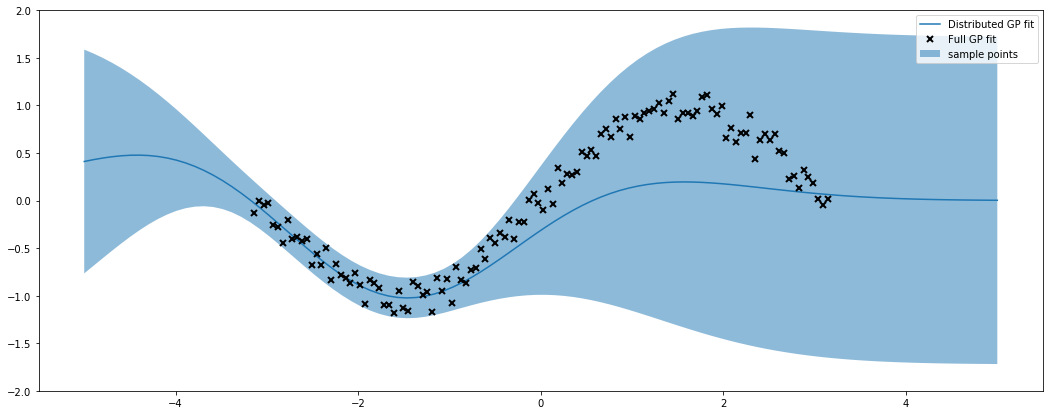

In [0]:
mean, Cov = dgp.Experts[0].predict(Xtest)
# Setup the figure environment
plt.figure(figsize=(18, 7))
# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)

## Barycenter 

In [0]:
dgp.Experts[0].k.getParamsExp()[0] + dgp.Experts[0].k.getParamsExp()[2]

0.7712762913672194

shapes  () (100,)
shapes  () (100,)
shapes  () (100,)
starting iterations...
n_iter:  1 , precision:  1001.9422617097158
n_iter:  2 , precision:  0.6121020953885582
n_iter:  3 , precision:  0.09865847687174019
n_iter:  4 , precision:  0.04260574173634464
n_iter:  5 , precision:  0.021498759127563983
n_iter:  6 , precision:  0.01199984114565332
n_iter:  7 , precision:  0.007192716748060446
n_iter:  8 , precision:  0.0044723658150790015
n_iter:  9 , precision:  0.0028189873622568758
n_iter:  10 , precision:  0.0017813862536646898
n_iter:  11 , precision:  0.0011238589409239806
n_iter:  12 , precision:  0.0007070906776360775
n_iter:  13 , precision:  0.000443696655498286
n_iter:  14 , precision:  0.0002778069764997116
n_iter:  15 , precision:  0.00017364558918792273
n_iter:  16 , precision:  0.00010840192001629995
n_iter:  17 , precision:  6.76102014386857e-05
n_iter:  18 , precision:  4.214074031784191e-05
n_iter:  19 , precision:  2.6253631034411496e-05
n_iter:  20 , precision:  1.63505

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: ComplexWarning:Casting complex values to real discards the imaginary part


 1002.0377285776057
n_iter:  2 , precision:  1.6286046129186476
n_iter:  3 , precision:  4.479357955480198
n_iter:  4 , precision:  32.50275914387743
n_iter:  5 , precision:  241.97398450791226
n_iter:  6 , precision:  1779.6290978245167
n_iter:  7 , precision:  22586.510391816537
n_iter:  8 , precision:  1183510.795523969
n_iter:  9 , precision:  180423861.49387246
n_iter:  10 , precision:  8024178051.882636
n_iter:  11 , precision:  79155543271.42618
n_iter:  12 , precision:  72205962532.61345
n_iter:  13 , precision:  29450927264.566223
n_iter:  14 , precision:  742929379906.3021
n_iter:  15 , precision:  739151024468.3812
n_iter:  16 , precision:  158781473783.5702
n_iter:  17 , precision:  154687105405.8176
n_iter:  18 , precision:  319779345066.7692
n_iter:  19 , precision:  316110707918.41925
n_iter:  20 , precision:  69245510690.26778
n_iter:  21 , precision:  351894846961.77203
n_iter:  22 , precision:  1937859646525.3943
n_iter:  23 , precision:  1877930445310.8594
n_iter:  2

 /usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:5108: ComplexWarning:Casting complex values to real discards the imaginary part
 /usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:5109: ComplexWarning:Casting complex values to real discards the imaginary part
 /usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:5112: ComplexWarning:Casting complex values to real discards the imaginary part
 /usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:5114: ComplexWarning:Casting complex values to real discards the imaginary part
 /usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning:Casting complex values to real discards the imaginary part


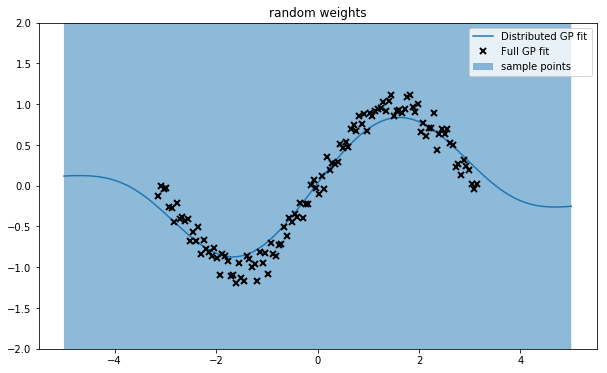

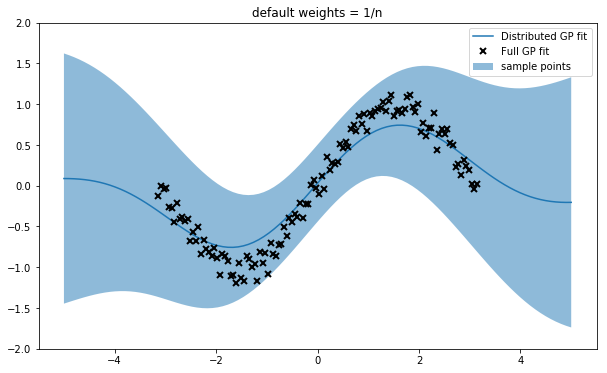

In [0]:
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)
#
ksi = np.random.rand(dgp.n) #random weights
ksi /= ksi.sum()
# print('experts coefs = ', ksi)
# ksi = np.zeros((dgp.n, N))
# for j in range(dgp.n):
#     ksi[j,j*(N//dgp.n):(j+1)*(N//dgp.n)] = 1

# Get mean and covariance for default all weights = 1/n
default_mean, default_Cov = dgp.gbarycenter(Xtest) 

# opt_mean, opt_Cov = dgp.gbarycenter(Xtest,ksi='opt')
mean, Cov = dgp.gbarycenter(Xtest,ksi='opt')
##############################
# plt.figure(figsize=(10,6))
# plot_dgp(Xtest, opt_mean.reshape(-1,1), opt_Cov, 0, 0, training_points=(X,y), full=False)
# # plt.plot(X, y, "kx", mew=2);
# plt.ylim(-2,2)
plt.figure(figsize=(10,6))
plot_dgp(Xtest, mean.reshape(-1,1), Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.title("random weights");
plt.ylim(-2,2)
plt.figure(figsize=(10,6))
plot_dgp(Xtest, default_mean.reshape(-1,1), default_Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
plt.title("default weights = 1/n");

In [0]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
# xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

## GP regression using GPy

In [0]:
# !pip3 install GPy

In [0]:
#import GPy
import GPy 
#create kernel
k = GPy.kern.RBF(1, variance=1., lengthscale=0.1, name="rbf")
#fit
gpmodel = GPy.models.GPRegression(X, y, k)
gpmodel.optimize();

In [0]:
# New test points to sample function from
N = 100
Xtest = np.linspace(-5, 5, N)[:, None]
# Use GPy model to calculate the mean and covariance of the fit at Xtest
mean, Cov = gpmodel.predict(Xtest, full_cov=True)

In [0]:
# Setup the figure environment
plt.figure(figsize=(18, 7))
# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, 0, 0, training_points=(X,y), full=False)
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)# Plot the GP fit mean and covariance
plt.title("GPy regression model fit");

In [0]:
class DGP(GPy.Model): #TODO
    def __init__(self, params, name='rosenbrock'):
        super(DGP, self).__init__(name=name)
        self.params = GPy.Param("input", params)
        self.add_parameter(self.params)
    def log_likelihood(self):
        return -scipy.optimize.rosen(self.params)
    def parameters_changed(self):
        self.params.gradient = -scipy.optimize.rosen_der(self.params)

In [0]:

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# import numpy as np
# import matplotlib.pylab as pl
# import ot

# Product of Experts

In [0]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_gpoe(Xtest)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

In [0]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
# xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# Generalized Product of Experts

In [0]:
## Define Weights 
betas = [1/dgp.n]*dgp.n
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_gpoe(Xtest, betas)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

In [0]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# BCM

In [0]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_bcm(Xtest)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

In [0]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# rBCM

In [0]:
# New test points to sample function from
Xtest = np.linspace(-5, 5, 100)[:, None]
# Get mean and covariance of optimised GP
mean, Cov = dgp.predict_rbcm(Xtest)
# Full GP
fullmean, fullCov = full_gp.predict(Xtest)

In [0]:
# Setup the figure environment
plt.figure(figsize=(18, 7))

# Plot the GP fit mean and covariance
plot_dgp(Xtest, mean.reshape(-1,1), Cov, fullmean.reshape(-1,1), fullCov, training_points=(X,y))
# plt.plot(X, y, "kx", mew=2);
plt.ylim(-2,2)
# xv = [X.min() + (X.max()-X.min())*j/(n-1) for j in range(dgp.n)]

# plt.vlines(xv, -2, 2);

# 2D - data (...)

In [0]:

# Lambda function, f, the unknown function we are trying to predict
f = lambda x: np.sin(x[:,0]) * np.sin(x[:,1])

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 120

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))
y2 = f(X2)

In [0]:
n = 3
dgp =  DistributedGPRegression(X2,y2,n)

In [0]:
dgp.train()

In [0]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
def z_func(x,y):
  X = np.array([x,y])[None,:]
  return f(X)[0]
 
x = arange(-3.0,3.0,0.1)
y = arange(-3.0,3.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

im = imshow(Z,cmap=cm.RdBu) # drawing the function
# adding the Contour lines with labels
cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im) # adding the colobar on the right
# latex fashion title
title('$z=sin(x_1)*sin(x_2)$')
show()

In [0]:
X_test = np.array([X.flatten(),Y.flatten()]).T
# dgp.predict(X_test)

In [0]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()